![alt text](https://www.msengineering.ch/typo3conf/ext/nm_theme_msengineering/Resources/Public/Template/img/mse_logo.jpg "MSE Logo") 

# AnTeDe Practical Work 5 : Topic Modeling

by Fabian Märki

## Summary
The aim of this lab is to get an understanding of [Latent Semantic Analysis](https://radimrehurek.com/gensim/models/lsimodel.html) and [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html) provided by [gensim](https://radimrehurek.com/gensim). 

Topic Modeling has many usecases:
- understanding the different varieties topics in a corpus (obviously)
- getting a better insight into the type of documents in a corpus (whether they are about news, wikipedia articles, business documents)
- quantifying the most used / most important words in a corpus
- document similarity and recommendation.
- etc.

### Sources
- https://www.kaggle.com/ktattan/lda-and-document-similarity
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python
- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence
- Heiko Hahn, AnTeDe 2019, theoretical questions

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !pip install mse-antede-fs2020-utilities
   
import os
import time
import numpy as np
import nltk
import gensim
import pandas as pd
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
import gensim
from gensim.models import LdaModel, LdaMulticore, LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim import models, corpora, similarities
import pyLDAvis.gensim
from scipy.stats import entropy
import matplotlib.pyplot as plt

from mse_antede_fs2020_utilities.preprocessing import TextPreprocessor
    
if IN_COLAB:
    nltk.download("popular")

Read the data...

In [2]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read().splitlines()
data_df = pd.DataFrame({'text': text})

# Data Preprocessing

Data preprocessing is key to success. Since both LSA and LDA are bag of words models, the words used for the model matter a lot (i.e. happy ≠ happier or bank ≠ banks). This means that it is crutial that you do a proper text cleaning, e.g. by focusing on the word roots (lemmatization/stemming or use nouns or adjectives only - see also [here](https://www.youtube.com/watch?v=3mHy4OSyRf0&t=6m34s) for further inspiration). As a consequence, we reduce the total number of unique words in the dictionary and can expect to get better topics generated in the end.

Here I use the TexpPreprocessor provided by [mse-antede-fs2020-utilities](https://pypi.org/project/mse-antede-fs2020-utilities). You are of course free to use your own code.

<font color='red'>Do not forget to tweak the code according your needs</font>

In [3]:
language = 'english'
stop_words = set(stopwords.words(language))
stop_words.add('\"')
stop_words.add('\'')
stop_words.add('\'\'')
stop_words.add('`')
stop_words.add('``')
stop_words.add('\'s')
# You: Extend the stop_word list if appropriate.

processor = TextPreprocessor(
    language = language,
    # You: Initialize the TextPreprocessor according your needs
    pos_tags = {wordnet.ADJ, wordnet.NOUN},
    stopwords = stop_words,
    # End of your code
    n_jobs = 6,
)

data_df['processed'] = processor.transform(data_df['text'])

In [4]:
data_df['tokenized'] = data_df['processed'].apply(nltk.word_tokenize)

The next bigram step is again from the orginal notebook. The idea is to recognize expressions like "new york" as one word, i.e. new_york, automatically.

In [5]:
# training for bigram collocation detection
phrases = Phrases(data_df['tokenized'], min_count=1, threshold=0.8, scoring='npmi')
bigram = Phraser(phrases)

In [6]:
# merging detected collocations with data
data_df['tokenized'] = list(bigram[data_df['tokenized']])

LSA and LDA are bag of words models, i.e. word order in a document does not count. This also means that stopwords and rare words should be excluded, so that the model does not overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.

In [7]:
# first get a list of all words
all_words = [word for item in data_df['tokenized'] for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

5011

In [8]:
# choose k and visually inspect the bottom 10 words of the top k
k = len(fdist) - 2263
top_k_words = fdist.most_common(k)
print(k)
print(top_k_words[:10])
print(top_k_words[-10:])

2748
[('mr', 306), ('australian', 178), ('new', 171), ('palestinian', 168), ('australia', 157), ('people', 153), ('government', 146), ('two', 136), ('u', 136), ('day', 131)]
[('shell', 1), ('jeep', 1), ('besiege', 1), ('nigel_hawthorne', 1), ('agent', 1), ('chemotherapy', 1), ('mcreddie', 1), ('unexpected', 1), ('mcreddie_brilliant', 1), ('sad', 1)]


k = 2843  seems to be reasonable as these have been used at least twice in the corpus. For a real world corpus you might want to set this threshold even higher. Words you definitely want to drop are all non-real words.


<font color='red'>Do not forget to tweak the code according your needs</font>

In [9]:
# define a function only to keep frequent words

# You: Define the thresholds according your needs
#min_freq = 1
#max_freq = 10000
min_freq = 5
max_freq = 200
def keep_freq_words(text):
    return [word for word in text if fdist[word] >= min_freq and fdist[word] <= max_freq]

In [10]:
data_df['tokenized'] = data_df['tokenized'].apply(keep_freq_words)
print("There are", len(list(filter(lambda x: x[1]>=min_freq, fdist.items()))), "of", len(fdist), "left.")

There are 1054 of 5011 left.


Topic modeling (especially LDA) does not work well with very short documents (see [here](https://stackoverflow.com/questions/29786985/whats-the-disadvantage-of-lda-for-short-texts) and [here](https://www.semanticscholar.org/paper/A-biterm-topic-model-for-short-texts-Yan-Guo/b7da93b0c797cdb2b5b31adc73224d625c0a0759)). This is why you might want to drop short articles of a real world corpus (e.g. under 40 tokens). 
This is because the model infers parameters from observations and if there are not enough observations (words) in a document, the model performs poorly.

In [11]:
# document length
doc_lengths = list(data_df['tokenized'].apply(lambda x: len(x)))

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 300 
average document length 62.5 
minimum document length 13 
maximum document length 224


# Nuber of Topics

Topic modeling is an unsupervised technique, meaning that we do not know prior to running the model how many topics exits in our corpus. Topic coherence is one of the main techniques used to estimate the number of topics (see [CoherenceModel](https://radimrehurek.com/gensim/models/coherencemodel.html)). There are several measures available to calculate the coherence score. Alternatively, one can also use visualization tools (like pyLDAvis for LDA), or tried a few numbers of topics and compared the results by hand.

We need to build many models with different number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [12]:
def compute_coherence_values(model, coherence='c_v'):
    """
    Compute coherence of a model

    Parameters:
    ----------
    model : The topic model
    coherence: The coherence measure to be used

    Returns:
    -------
    coherence_value : Coherence value corresponding to the model with respective number of topics
    """

    coherencemodel = CoherenceModel(model=model, texts = data_df['tokenized'], corpus=corpus, dictionary=dictionary, coherence=coherence)

    return coherencemodel

The main reference is this [paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) and a good start [this](https://rare-technologies.com/what-is-topic-coherence).

<font color='red'>Please describe the coherence process by explaining its main four steps (figure one in the original paper) in your own words.</font>

<font color='green'> At an abstract level, coherence criteria try to quantify how much (top ranked) words from a topic are semantically consistent. The topic coherence process is a way to automatically measure this coherence and it consists of the following four steps<br></font>  
 <font color='blue'>Segmentation:</font> <font color='green'> The segmentation part defines how to divide the set containing the top ranking words for the coherence calculations. For example, do you want to compare each word from the top ranking set against each other word or do you want to compare one word from this set with the set of all remaining words from the top ranking words etc. We have the option to choose from different schemes on how to segments these top ranking word into sets. <br>
<font color='blue'>Probability Calculations</font> The coherence measures are based on probabilities of occurrence of single words and on the probabilities of the cooccurrence of certain words together in documents. In its simplest (Boolean) form this just means counting the occurrence of a word or the cooccurrence of certain words in documents and divide these counts by the total number of documents. Alternatively, by using a sliding window approach you define smaller virtual documents that are created by the respective document parts that are covered as the window slides over the documents. You derive the probability estimates from that extended virtual documents corpus <font color='green'> <br>
<font color='blue'>Confirmation measure</font>Having calculated probabilities for the occurrence of words or the cooccurrence of certain words together you now derive your confirmation measure by setting these probabilities in relation, e.g. multiplying and/or dividing them. One example is by calculating pointwise mutual information. Several different confirmation measures are available.<br>
<font color='blue'>Aggregation measure</font> As the confirmation measure is calculated for pairs of words or set of words the final step is the aggregation of this single confirmation measures in one aggregated measure.</font>

<font color='red'>Please have a look at the interface of [gensim.models.coherencemodel](https://radimrehurek.com/gensim/models/coherencemodel.html). One of the the parameters is coherence. There you find a list of abbreviations like 'u_mass' etc which stand for the actual coherence measure. Please select two of them and explain in a few words how they are calculated and what they measure.</font>

<font color='green'>This is about the choice of the coherence measure. Lets look at c_uci/c_pmi and u_mass<br></font>  
 <font color='blue'>c_uci/c_pmi :</font> <font color='green'>This is the pointwise mutual information $pmi=\log {\frac {p(w_i,w_j)+\epsilon}{p(w_i)p(w_j)}}$ where we compare the log probabilities of observing the words together with the probability of observing them independently <font color='green'> <br>
 <font color='blue'>c_mass :</font> For calculating $c_{mass}=\log {\frac {p(w_i,w_j)+\epsilon}{p(w_i)}}$ we compare the log probability of observing both words together with the probability of observing just one word.
<br>In both case the value will be higher if we see the words often together. The denominator is a weighting factor for the term frequency so that very frequent words do not get too much weight [see also here](https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense) <font color='green'>  

In [13]:
def show_coherence_graph(start, limit, step, coherence_values, coherence_names):
    # Show graph
    x = range(start, limit, step)
    fig, axs = plt.subplots(len(coherence_values))
    
    for i, coherence_name in enumerate(coherence_names):
        coherence_vals = coherence_values[coherence_name]
        axs[i].plot(x, coherence_vals)
        axs[i].set_xlabel("Num Topics")
        axs[i].set_ylabel("Coherence Value")
        axs[i].legend((coherence_name), loc='best')

    plt.show()

# LSA


Latent Semantic Analysis is a classical tool for automatically extracting similarities between documents, through dimensionality reduction. By applying TF-IDF as a preprocessing step, it is possible to fill the document-term matrix with weights corresponding to the importance of the term in the specific document. The document-term matrix is then reduced via Singular Value Decomposition to a lower dimensional space (often called the concept space) by a rank k approximation of the document-term matrix. This representation is then used to compare documents by e.g. using the cosine distance.

<font color='red'>Please implement the function <b>train_lsa</b> by following [this tutorial](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html). Also consider using a TF-IDF transformation.</font>

In [14]:
def train_lsa(data, num_topics = 10):
    """
    This function trains the lsa model
    We setup parameters like number of topics
    """

    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    t1 = time.time()
    
    # Start: Add your code
    # Lets us tf-idf
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    chunksize = 20
    lsa = LsiModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=dictionary, chunksize=chunksize)
    # End: Add your code
    
    t2 = time.time()
    print("Time to train a", num_topics, "topics LSA model on", len(data), "articles:", (t2-t1)/60, "min")
    return lsa,dictionary,corpus,corpus_tfidf

## LSA - Nuber of Topics

Lets perform a hyper-parameter tuning in order to find the optimal number of topics. 

Time to train a 2 topics LSA model on 300 articles: 0.007224476337432862 min
Time to train a 3 topics LSA model on 300 articles: 0.01815900405248006 min
Time to train a 4 topics LSA model on 300 articles: 0.017794462045033772 min
Time to train a 5 topics LSA model on 300 articles: 0.02167640527089437 min
Time to train a 6 topics LSA model on 300 articles: 0.018404078483581544 min
Time to train a 7 topics LSA model on 300 articles: 0.022061129411061604 min
Time to train a 8 topics LSA model on 300 articles: 0.020171181360880534 min
Time to train a 9 topics LSA model on 300 articles: 0.020653752485911052 min
Time to train a 10 topics LSA model on 300 articles: 0.022107315063476563 min
Time to train a 11 topics LSA model on 300 articles: 0.030411851406097413 min
Time to train a 12 topics LSA model on 300 articles: 0.02240130106608073 min
Time to train a 13 topics LSA model on 300 articles: 0.022495591640472413 min
Time to train a 14 topics LSA model on 300 articles: 0.0230611522992452 min

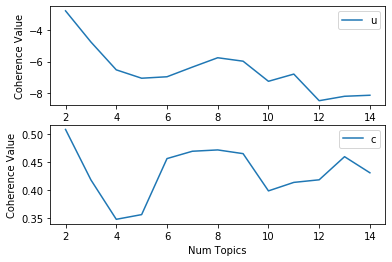

In [15]:
start=2
limit=15
step=1
coherences = ['u_mass', 'c_v']
# dic of lists
coherence_values = {}
for coherence in coherences:
    coherence_values[coherence] = []
model_list = []

for num_topics in range(start, limit, step):
    model,dictionary,corpus,corpus_tfidf = train_lsa(data_df['tokenized'], num_topics = num_topics)
    model_list.append((model,dictionary,corpus,corpus_tfidf))
    
    for coherence in coherences:
        coherencemodel = compute_coherence_values(model, coherence)
        coherence_values[coherence].append(coherencemodel.get_coherence())
    
show_coherence_graph(start, limit, step, coherence_values, coherences) 

In [16]:
best_topic_index = 7
model,dictionary,corpus,corpus_tfidf = model_list[best_topic_index]

Let's inspect some topics. When we see the words they may seem shortened. This is because of our lemmanized/stemmed the words.

In [17]:
model.print_topics(num_topics=5, num_words=20)

[(0,
  '0.251*"palestinian" + 0.165*"israeli" + 0.123*"afghanistan" + 0.117*"force" + 0.116*"arafat" + 0.116*"government" + 0.115*"fire" + 0.112*"attack" + 0.111*"u" + 0.102*"australia" + 0.096*"australian" + 0.094*"security" + 0.094*"israel" + 0.093*"people" + 0.091*"hamas" + 0.091*"new" + 0.089*"police" + 0.087*"leader" + 0.085*"official" + 0.084*"two"'),
 (1,
  '0.442*"palestinian" + 0.299*"israeli" + 0.212*"arafat" + -0.185*"test" + 0.155*"israel" + 0.153*"hamas" + 0.122*"suicide" + -0.119*"south" + 0.117*"militant" + 0.107*"sharon" + -0.105*"sydney" + -0.103*"australia" + -0.102*"australian" + 0.098*"west_bank" + -0.095*"yacht" + -0.092*"africa" + -0.086*"union" + 0.085*"gaza" + -0.082*"race" + 0.080*"gaza_strip"'),
 (2,
  '0.283*"test" + 0.208*"fire" + -0.196*"afghanistan" + 0.172*"south" + 0.172*"palestinian" + 0.166*"africa" + 0.134*"israeli" + -0.128*"qantas" + 0.125*"match" + 0.124*"wicket" + -0.123*"union" + 0.121*"cricket" + -0.120*"taliban" + -0.114*"hick" + -0.114*"al_qae

<font color='red'>Do you find the output useful? Please make a comment.</font>

<font color='green'>This is a very open question so there are no clear true or false answers. But it is certainly not easy from these outputs to make any clear interpretation of the main topics being discussed. One aspect is that there seem to be very similar topics at the top.</font>

## LSA - Query Documents

There is one tasks missing from the lecture and that is the problem of finding similar documents. Please implement the similarity evaluation from Lab4 between query document $\mathbf{q}$ and our document corpus. It might be helpful to consult the following [tutorial](https://radimrehurek.com/gensim/tut3.html). Your are only asked to calculate the (cosine) similarity values and not to reproduce the complete tutorial. 
 

<font color='red'>Please implement the document query: "Qantas airline was late today."</font>

In [18]:
index = similarities.MatrixSimilarity(model[corpus_tfidf])

pd_queries = pd.DataFrame({'queries_text': ["Qantas airline was late today."]})
# simple test -> must return itself
#pd_queries['queries_text'] = data_df['text'].iloc[0]
pd_queries['queries_processed'] = processor.transform(pd_queries['queries_text'])
pd_queries['queries_tokenized'] = pd_queries['queries_processed'].apply(nltk.word_tokenize)
# consider Phraser
pd_queries['queries_tokenized'] = bigram[pd_queries['queries_tokenized']]
pd_queries['queries_tokenized'] = pd_queries['queries_tokenized'].apply(keep_freq_words)
vec_bow = dictionary.doc2bow(pd_queries['queries_tokenized'].iloc[0])
vec_lsi = model[vec_bow]

sims = index[vec_lsi]  # perform a similarity query against the corpus
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print("Query:",pd_queries['queries_text'].iloc[0])
for i in range(0, 10):
    print(i, sims[i], data_df['text'].iloc[sims[i][0]])

Query: Qantas airline was late today.
0 (128, 0.9922518) Qantas has moved to assure travellers there will be no disruption to flights over the Christmas period, despite threats of industrial action. Qantas maintenance workers have rejected the airline's proposals for a wage freeze. As negotiations over the dispute continue in the Industrial Relations Commission, Qantas Chief Executive Geoff Dixon has expressed his disappointment at the maintenance workers' actions. Mr Dixon points out 92 per cent of the airline's workforce have already agreed in-principle to accept a wages freeze together with an incentives scheme. Mr Dixon claims maintenance workers earn, on average, 28 per cent above average weekly earnings and also receive generous staff travel benefits. Mr Dixon has assured nervous travellers that even if the workers do go out on strike, Qantas flights will not be disrupted. Maintenance unions are refusing to soften their stance against a Qantas wage freeze proposal. Qantas and two

# LDA

Latent Dirichlet Allocation, is an unsupervised generative model that assigns topic distributions to documents.

At a high level, the model assumes that each document will contain several topics, so that there is topic overlap within a document. The words in each document contribute to these topics. There can be words overlap between topics, so several topics may share the same words. The topics may not be known and do not need to be specified a priori, but the number of topics must be specified a priori. 

After training, each document will have a discrete distribution over all topics, and each topic will have a discrete distribution over all words. I.e. the model generates following latent (hidden) variables: 
- A distribution over topics for each document
- A distribution over words for each topics

### Hyperparameters

LDA has 2 hyperparameters: α and η

α: A low value for α means that documents have only a low number of topics contributing to them. A high value of α yields the inverse, meaning the documents appear more alike within a corpus.

η: A low value for η means the topics have a low number of contributing words. A high value of η yields the inverse, meaning topics will have word overlap and appear more alike.

The values of α and η depend on the application, and may need to be tweaked several times before the desired results are found. [Gensim's implementation](https://radimrehurek.com/gensim/models/ldamodel.html) allows to use `auto` in order to learn an asymmetric prior from the corpus. In addition, there is also a [multicore implementation](https://radimrehurek.com/gensim/models/ldamulticore.html) available.  

Please note: LDA is non-deterministic (i.e. parameters are randomly initialised). As a consequence, the outcome from run to run might differ.

<font color='red'>Please implement the function <b>train_lda</b>. Also have a look above to get an idea of possible options.</font>

In [19]:
def train_lda(data, num_topics = 10, alpha='auto', eta='auto'):
    """
    This function trains the lda model
    We setup parameters like number of topics
    """
    #chunksize = 300
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    # alpha=1e-2, eta=0.5e-2,
    # , per_word_topics=True, , minimum_probability=0.0
    chunksize = 20
    passes=30
    if alpha is 'auto':
        lda = LdaModel(alpha=alpha, eta=eta, corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, passes=passes)
    else:
        lda = LdaMulticore(alpha=alpha, eta=eta, corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, passes=passes, workers=6)
        
    t2 = time.time()
    print("Time to train a", num_topics, "topics LDA model on", len(data), "articles:", (t2-t1)/60, "min")
    return lda,dictionary,corpus

## LDA - Nuber of Topics

Lets perform a hyper-parameter tuning in order to find the optimal number of topics. 

Time to train a 2 topics LDA model on 300 articles: 0.06455207268397013 min
Time to train a 3 topics LDA model on 300 articles: 0.08222708702087403 min
Time to train a 4 topics LDA model on 300 articles: 0.08269790013631186 min
Time to train a 5 topics LDA model on 300 articles: 0.08857887188593547 min
Time to train a 6 topics LDA model on 300 articles: 0.06810965538024902 min
Time to train a 7 topics LDA model on 300 articles: 0.06723330020904542 min
Time to train a 8 topics LDA model on 300 articles: 0.06742271979649862 min
Time to train a 9 topics LDA model on 300 articles: 0.06802940368652344 min
Time to train a 10 topics LDA model on 300 articles: 0.06888451178868611 min
Time to train a 11 topics LDA model on 300 articles: 0.06710737943649292 min
Time to train a 12 topics LDA model on 300 articles: 0.08825973272323609 min
Time to train a 13 topics LDA model on 300 articles: 0.07349321842193604 min
Time to train a 14 topics LDA model on 300 articles: 0.07836623191833496 min


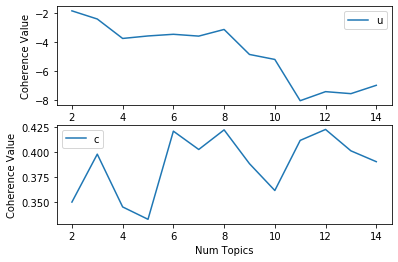

In [20]:
start=2
limit=15
step=1
coherences = ['u_mass', 'c_v']
# dic of lists
coherence_values = {}
for coherence in coherences:
    coherence_values[coherence] = []
model_list = []

for num_topics in range(start, limit, step):
    model,dictionary,corpus = train_lda(data_df['tokenized'], num_topics = num_topics)
    model_list.append((model,dictionary,corpus))
    
    for coherence in coherences:
        coherencemodel = compute_coherence_values(model, coherence)
        coherence_values[coherence].append(coherencemodel.get_coherence())
    
show_coherence_graph(start, limit, step, coherence_values, coherences) 

In [21]:
best_topic_index = 7
model,dictionary,corpus = model_list[best_topic_index]

Let's inspect some topics. When we see the words they may seem shortened. This is because of our lemmanized/stemmed the words.

Note that if you re run the model again, as it is non-deterministic, word contributions to topics and topic ID's will change.

In [22]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
model.show_topics(num_topics=num_topics, num_words=5)

[(0,
  '0.055*"company" + 0.034*"like" + 0.027*"right" + 0.026*"family" + 0.025*"change"'),
 (1,
  '0.039*"union" + 0.034*"commission" + 0.023*"child" + 0.021*"party" + 0.020*"qantas"'),
 (2,
  '0.042*"attack" + 0.033*"force" + 0.029*"official" + 0.027*"group" + 0.027*"security"'),
 (3,
  '0.109*"palestinian" + 0.078*"israeli" + 0.046*"arafat" + 0.030*"hamas" + 0.029*"israel"'),
 (4,
  '0.041*"government" + 0.036*"australia" + 0.023*"afghanistan" + 0.021*"taliban" + 0.018*"federal"'),
 (5,
  '0.042*"australia" + 0.028*"metre" + 0.025*"test" + 0.025*"south" + 0.024*"day"'),
 (6,
  '0.035*"near" + 0.034*"bombing" + 0.030*"kandahar" + 0.027*"airport" + 0.022*"race"'),
 (7,
  '0.042*"australian" + 0.031*"u" + 0.027*"year" + 0.024*"new" + 0.021*"world"'),
 (8,
  '0.036*"city" + 0.030*"fire" + 0.024*"sydney" + 0.022*"around" + 0.022*"storm"')]

In [23]:
model.show_topic(topicid=0, topn=20)

[('company', 0.054855514),
 ('like', 0.034457415),
 ('right', 0.027046565),
 ('family', 0.026241047),
 ('change', 0.025209555),
 ('guide', 0.021910513),
 ('human', 0.020951293),
 ('adventure', 0.02017744),
 ('case', 0.017778723),
 ('reserve', 0.016111735),
 ('growth', 0.01576839),
 ('level', 0.015229363),
 ('possible', 0.0150897745),
 ('administrator', 0.0147122545),
 ('virus', 0.013660982),
 ('tomorrow', 0.01330117),
 ('interlaken', 0.013287692),
 ('sector', 0.013247095),
 ('trip', 0.013018504),
 ('tragedy', 0.012326697)]

<font color='red'>What is "show_topics()"" displaying in terms of the variables/approximation that were introduced in the lecture?</font>

<font color='green'> In a LDA model, a topic is defined as a distribution over the vocabulary. In the figure above this refers to the $\lambda_k$/$\beta_k$ variable and this is displayed by "show_topics()". Show_topics allows to specify the number of topics by parameter "num_topics" and also the number of words per topic by parameter "num_topics". So not the whole vocabulary is displayed but only those with the highest probability under a certain topic</font>

In [24]:
bow = dictionary.doc2bow(data_df['tokenized'].iloc[0])
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in model.get_document_topics(bow=bow)])
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, model.show_topic(topicid=i, topn=10), "\n")

6 [('near', 0.035177197), ('bombing', 0.03380723), ('kandahar', 0.030278502), ('airport', 0.02692409), ('race', 0.022467477), ('radio', 0.02110409), ('mountain', 0.020621888), ('eight', 0.019871589), ('boat', 0.019832399), ('half', 0.019052222)] 

3 [('palestinian', 0.10909346), ('israeli', 0.07752224), ('arafat', 0.046135433), ('hamas', 0.029677832), ('israel', 0.029126571), ('rate', 0.026314143), ('sharon', 0.022901118), ('west_bank', 0.022132808), ('arrest', 0.022003017), ('militant', 0.018427063)] 

5 [('australia', 0.042094164), ('metre', 0.027702577), ('test', 0.024904808), ('south', 0.024533564), ('day', 0.023881605), ('match', 0.0233328), ('second', 0.023059499), ('centre', 0.021417089), ('hit', 0.018963782), ('third', 0.017490832)] 

4 [('government', 0.04111046), ('australia', 0.03639039), ('afghanistan', 0.022669602), ('taliban', 0.021327345), ('federal', 0.018133765), ('claim', 0.016327586), ('al_qaeda', 0.014739818), ('economy', 0.014000628), ('september', 0.0134613635), (

There is also a human-based evaluation approach. A well known paper that explains it is [this](https://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models). This [one](http://www.aclweb.org/anthology/E14-1056) even tries to automate it.

<font color='red'>Please explain what word intrusion means.</font>

<font color='green'> For the word intrusion tasks a random word is added to the set of top-rated words from a topic. If a human easily detects the added word from the set of top-rated topic words then the topic models fails this test</font>  

<font color='red'>Please explain what topic intrusion means.</font>

<font color='green'>For the topic intrusion tasks a document snippet and the topics that are highest ranked by the topic model algorithm for that document are presented to a human. In addition, a low ranked topic is added that does not belong to the set of highest ranked topic for that document. The subject is instructed to choose the topic which does not belong to the document. If a human easily detects the added topic then the topic models fails this test</font>  

<font color='red'>Do you find the result (found topics) useful? Do you think you got an idea what the texts are discussing? Please make a comment.</font>

<font color='green'>This is a very open question so there are no clear true or false answers. But it is certainly not easy from these outputs to make any clear interpretation of the main topics being discussed. One aspect is that very generic words rank quite high like "one" or "much" or "ever" that are not really helpful here.</font>

pyLDAVis is a nice way to visualise the information contained in a topic model.

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.232482  0.210581       1        1  23.847788
2      0.118484 -0.108774       2        1  15.339815
4     -0.038313 -0.310637       3        1  14.586185
8     -0.163126 -0.126414       4        1  10.019035
1      0.267484  0.144815       5        1   9.250775
5     -0.177978  0.101978       6        1   9.026424
3      0.049157 -0.003865       7        1   7.789957
6      0.038359  0.038502       8        1   5.316044
0      0.138414  0.053814       9        1   4.823972, topic_info=            Term        Freq       Total Category  logprob  loglift
385  palestinian  160.000000  160.000000  Default  30.0000  30.0000
381      israeli  114.000000  114.000000  Default  29.0000  29.0000
392   australian  187.000000  187.000000  Default  28.0000  28.0000
104    australia  171.000000  171.000000  Default  27.0000  27.0000
67        attack  122.000000  122.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
413     possible   13.648622   18.755966   Topic9  -4.1937   2.7137
699     tomorrow   12.030839   20.100689   Topic9  -4.3199   2.5183
62       weather    9.761194   19.078232   Topic9  -4.5290   2.3614
567        water   10.027860   24.015442   Topic9  -4.5020   2.1582
41         place    9.406039   33.218006   Topic9  -4.5660   1.7698

[382 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
452       5  0.912186          1,000
361       8  0.954653          5,000
103       7  0.908199            act
158       1  0.972623         action
271       4  0.943712       activity
...     ...       ...            ...
532       2  0.986253  yasser_arafat
65        1  0.995985           year
102       1  0.437382      yesterday
102       2  0.099405      yesterday
102       6  0.437382      yesterday

[419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 5, 9, 2, 6, 4, 7, 1])

<font color='red'>What is the meaning of the adjustable lambda scroll bar and what does it control?</font>

<font color='green'>At abstract level the lambda bar let you filter out non-representative words that are highly associated with the topic that you have selected (topics can be selected in the upper left corner). By moving lambda you can balance the listing of words that are important to your topic in general (but that might not be exclusively used in the context of that particular topic) and words that are only associated to a larger degree with that specific topic. So low lambda will choose exclusive words (even some specific (technical) slang words) and larger lambda  will choose that are in general important to your (and possibly other) topics

<font color='red'>What do the blue and red bars indicate?</font>

<font color='green'>A word with a larger blue bar is generally found in many topics (as it would have a high overall term frequency) and a words with a red bar is more exclusively associated with that particular topic you are analyzing</font>

If you are familiar with the subject of the articles in this dataset, you can judge if the topics above make sense. However, they might not be without flaws. There might be substantial overlap between some topics, others are hard to interpret, and most of them have at least some terms that seem out of place.

There are also other approaches to evaluate Topic Models such as Perplexity. Topic Visualization is also a good way to assess topic models. Topic Coherence measure is a good way to compare difference topic models based on their human-interpretability. The aim of the Coherence measure (e.g. u_mass or c_v) is to capture the optimal number of topics by giving the interpretability of these topics.

## LDA - Query Documents

Let's say we wanted to find the most similar documents in the corpus. We can do this by comparing the topic distribution of the new document to all the topic distributions of the documents in the corpus. We use the [Jensen-Shannon distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) metric to find the most similar documents.

What the Jensen-Shannon distance tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A.

<font color='red'>Do not forget to tweak the code below</font>

In [29]:
def calc_similarity(query, doc_topic_distributions):
    """
    This function implements a similarity measure (e.g. Jensen-Shannon similarity)
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """

    # your task: implement jenson_shannon (consider using gensim.matutils.jensen_shannon)
    # return np.ones(len(matrix))
    
    return np.array([gensim.matutils.jensen_shannon(query, element) for  element in doc_topic_distributions])
    #return np.array([gensim.matutils.hellinger(query, element) for  element in doc_topic_distributions])


    #p = query[None,:].T # take transpose
    #q = matrix.T # transpose matrix
    #m = 0.5*(p + q)
    #return np.sqrt(0.5 * (entropy(p,m) + entropy(q,m)))



def get_most_similar_documents(query,doc_topic_distributions,k=10):
    """
    This function calculates the top k most similar documents based on the similarity measure implemented by calc_similarity
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = calc_similarity(query, doc_topic_distributions) # list of (index, distances)
    sims = sorted(enumerate(sims), key=lambda item: item[1])
    return sims[:k] # the top k positional index of the smallest distances



<font color='red'>Choose a document and search for the most similar other documents (e.g. the one with id 128).</font>

In [30]:
# use nested list comprehension here
doc_topic_dist = np.array([np.array([tup[1] for tup in lst]) for lst in model.get_document_topics(bow=corpus, minimum_probability=0.0)])

# this is also a simple test -> must return itself
pd_queries['queries_text'] = data_df['text'].iloc[128]
pd_queries['queries_processed'] = processor.transform(pd_queries['queries_text'])
pd_queries['queries_tokenized'] = pd_queries['queries_processed'].apply(nltk.word_tokenize)
# consider Phraser
pd_queries['queries_tokenized'] = bigram[pd_queries['queries_tokenized']]
pd_queries['queries_tokenized'] = pd_queries['queries_tokenized'].apply(keep_freq_words)
vec_bow = dictionary.doc2bow(pd_queries['queries_tokenized'].iloc[0])
# get the topic contributions for the document 
doc_distribution = np.array([tup[1] for tup in model.get_document_topics(bow=vec_bow, minimum_probability=0.0)])

sims = get_most_similar_documents(doc_distribution, doc_topic_dist, k = 10)
print("Query:",pd_queries['queries_text'].iloc[0])
print(sims)
for i in range(0, 10):
    print(i, sims[i], data_df['text'].iloc[sims[i][0]])

Query: Qantas has moved to assure travellers there will be no disruption to flights over the Christmas period, despite threats of industrial action. Qantas maintenance workers have rejected the airline's proposals for a wage freeze. As negotiations over the dispute continue in the Industrial Relations Commission, Qantas Chief Executive Geoff Dixon has expressed his disappointment at the maintenance workers' actions. Mr Dixon points out 92 per cent of the airline's workforce have already agreed in-principle to accept a wages freeze together with an incentives scheme. Mr Dixon claims maintenance workers earn, on average, 28 per cent above average weekly earnings and also receive generous staff travel benefits. Mr Dixon has assured nervous travellers that even if the workers do go out on strike, Qantas flights will not be disrupted. Maintenance unions are refusing to soften their stance against a Qantas wage freeze proposal. Qantas and two maintenance unions are continuing negotiations in